In [0]:
# uninstall older version and install tensorflow 2.0
!pip uninstall tensorflow
!pip install tensorflow==2.0.0-beta1

Please restart the colab so as to make the tf 2.0 be effective. 

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import urllib
from os import listdir
from os.path import isdir
import shutil
from PIL import Image
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.python.keras import models

# Snake Game: Alpha Version

This document is for playing snake game with using your head gestures. Our work was inspired by google [Pac-Man](https://storage.googleapis.com/tfjs-examples/webcam-transfer-learning/dist/index.html) demo. If you're intrested, this notebook could be run end-to-end but it would take 20 minutes or so. 

## Step 0: Create Dataset

Here we downloaded our original dataset from [head pose image database](http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html). The head pose database is a benchmark of 2790 monocular face images of 15 persons with variations of pan and tilt angles from -90 to +90 degrees. However, in our project, only four directions (up, down, left and right) are needed. Therefore, we classified all images in the database into four directions based on tester head's tilt and pan. The criteria is shown as follow.

![split-criteria](http://www.columbia.edu/~hl3099/split-criteria.png)

In [0]:
dataset = "http://www-prima.inrialpes.fr/perso/Gourier/Faces/HeadPoseImageDatabase.tar.gz"
urllib.request.urlretrieve(dataset,'data.tar.gz') 

('data.tar.gz', <http.client.HTTPMessage at 0x7f4605c95978>)

In [0]:
# tar file
!mkdir data
!mkdir headpose
!tar -C ./data -zxvf data.tar.gz

In [0]:
def createDataset(input_path, output_path):
  personfolders = listdir(input_path)
  for person in personfolders:
    path = input_path + person
    if isdir(path):
      imagesList = listdir(path)
      for image in imagesList:
        image_path = path + '/' + image
        if image[::-1][:4] == '.jpg'[::-1]:
            image_name = image[::-1][:10][::-1]
            output_name = output_path + image[::-1][4:][::-1]
            if person == 'start':
                shutil.copy(image_path, output_name + 'start.jpg')
            elif person == 'Front':
                shutil.copy(image_path, output_name + 'front.jpg')
            else:
                tilt = int(re.findall('[+-]{1}[0-9]*',image_name)[0])
                pan = int(re.findall('[+-]{1}[0-9]*',image_name)[1])
                if abs(tilt) <= 15 and abs(pan) <= 15:
                    shutil.copy(image_path, output_name + 'front.jpg')
                elif tilt <= -30 and abs(pan) <= 45:
                    shutil.copy(image_path, output_name + 'down.jpg')
                elif tilt >= 30 and abs(pan) <= 45:
                    shutil.copy(image_path, output_name + 'up.jpg')   
                elif (abs(tilt) > 30 and pan < -45) or (abs(tilt) <= 15 and pan < -15):
                    shutil.copy(image_path, output_name + 'left.jpg') 
                elif (abs(tilt) > 30 and pan > 45) or (abs(tilt) <= 15 and pan > 15):
                    shutil.copy(image_path, output_name + 'right.jpg')

In [0]:
createDataset('./data/','./headpose/')

## Step 1: Load Images and Pre-process

### (a) load images

In [0]:
def name2label(name):
  label_dict = {'front':0, 'up':1, 'down':2, 'left': 3, 'right': 4}
  direction = re.findall('[0-9]{1}[a-z]+',name)[0][1:]
  return label_dict[direction]

def loadImages(path, imgH, imgW):
  imagesList = listdir(path)
  loadedImages = []
  labels = []
  for image in imagesList:
    try:
      img = Image.open(path + image)
    except:
      continue
    if img.mode != 'RGB':
      continue
    img = img.resize((width, height))
    loadedImages.append(img)
    img_label = name2label(image)
    labels.append(img_label) 
  return loadedImages, labels

In [0]:
height = 224
width = 224

images, labels = loadImages('./headpose/', height, width)

### (b)data augmentation

Since we care about the generalization ability of our model more, we applied some data augmentation techniques, such as translation and adding noise on our original dataset. One thing needed to be pointed out is that here we did not flip our data because directions matter in our model.  

In [0]:
def data_aug(x, flip=False):
  
  x = np.expand_dims(x,0)
  # left-translation with 10px
  x1 = tf.image.pad_to_bounding_box(x, 0, 10, 224, 234)
  x1 = tf.image.crop_to_bounding_box(x1, 0, 0, 224, 224).numpy()[0]
  
  # top-translation with 10px
  x2 = tf.image.pad_to_bounding_box(x, 10, 0, 234, 224)
  x2 = tf.image.crop_to_bounding_box(x2, 0, 0, 224, 224).numpy()[0]
  
  # right-translation with 10px
  x3 = tf.image.pad_to_bounding_box(x, 0, 0, 224, 234)
  x3 = tf.image.crop_to_bounding_box(x3, 0, 10, 224, 224).numpy()[0]
  
  # bottom-translation with 10px
  x4 = tf.image.pad_to_bounding_box(x, 0, 0, 234, 224)
  x4 = tf.image.crop_to_bounding_box(x4, 10, 0, 224, 224).numpy()[0]
  
  # add noise
  noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=100,dtype=tf.float32)
  x5 = tf.add(x, noise).numpy()[0]
  
  if flip:
    x6 = tf.image.flip_up_down(x).numpy()[0]
    x7 = tf.image.flip_left_right(x).numpy()[0]
    return [x[0],x1,x2,x3,x4,x5,x6,x7]                       
  else:
    return [x[0],x1,x2,x3,x4,x5] 
                           

### (c) preprocessing

Since our data is unbalanced which could have a great effect on training and prediction. Therefore, we resampled the augmented dataset a little bit so as to make it more balanced.

In [0]:
def preprocess_images(imagesList, labels):
  n =  len(images)
  images_array = []
  labels_aug = []
  for i in range(n):
    thres = np.random.uniform(size=1)
    if labels[i] == 0 and thres < 0.7:
      images_aug = data_aug(np.asarray(imagesList[i], dtype='float32'))
      images_array += images_aug
      labels_aug += [labels[i]]*6
    elif labels[i] == 1 and thres < 0.5:
      images_aug = data_aug(np.asarray(imagesList[i], dtype='float32'))
      images_array += images_aug
      labels_aug += [labels[i]]*6
    elif labels[i] == 2 and thres < 0.5:
      images_aug = data_aug(np.asarray(imagesList[i], dtype='float32'))
      images_array += images_aug
      labels_aug += [labels[i]]*6
    elif labels[i] == 3 and thres < 0.3:
      images_aug = data_aug(np.asarray(imagesList[i], dtype='float32'))
      images_array += images_aug
      labels_aug += [labels[i]]*6
    elif labels[i] == 4 and thres < 0.3:
      images_aug = data_aug(np.asarray(imagesList[i], dtype='float32'))
      images_array += images_aug  
      labels_aug += [labels[i]]*6 
  images_array = np.asarray(images_array,dtype='float32') / 127.5 - 1  #refer keras image preprocessing utils(tf mode)
  return images_array, labels_aug

In [0]:
np.random.seed(123)
images_array, labels_array = preprocess_images(images, labels)
labels_array = np.array(labels_array)
print(images_array.shape)

(6312, 224, 224, 3)


In [0]:
np.unique(labels_array,return_counts=True)

(array([0, 1, 2, 3, 4]), array([1230, 1296, 1392, 1146, 1248]))

### (d) shuffle dataset

In [0]:
images_array, labels_array = shuffle(images_array, labels_array, random_state=42)

## Step 2: Train Model

Here, we used the idea of transfer learning to build our model. Our base model is mobile net which is small but powerful.

In [0]:
mobile_net = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False  #non-trainable

In [0]:
# mobile_net.summary()

In [0]:
features = mobile_net.predict(images_array)

In [0]:
snake_model= tf.keras.Sequential([ 
  tf.keras.layers.Flatten(input_shape=(7,7,1024,)),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(256,activation='softmax'),
  tf.keras.layers.Dense(6,activation='softmax')])

In [0]:
snake_model.compile(optimizer=tf.optimizers.Adam(1e-4), 
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])
history=snake_model.fit(features,labels_array,batch_size=256,epochs=30,validation_split=0.2)

Train on 5049 samples, validate on 1263 samples
Epoch 1/30
5049/5049 [==============================] - 6s 1ms/sample - loss: 1.7402 - accuracy: 0.3981 - val_loss: 1.7030 - val_accuracy: 0.5091
Epoch 2/30
5049/5049 [==============================] - 5s 1ms/sample - loss: 1.6939 - accuracy: 0.5546 - val_loss: 1.6778 - val_accuracy: 0.6073
Epoch 3/30
5049/5049 [==============================] - 5s 1ms/sample - loss: 1.6761 - accuracy: 0.6189 - val_loss: 1.6685 - val_accuracy: 0.6643
Epoch 4/30
5049/5049 [==============================] - 5s 1ms/sample - loss: 1.6662 - accuracy: 0.6621 - val_loss: 1.6623 - val_accuracy: 0.6595
Epoch 5/30
5049/5049 [==============================] - 5s 1ms/sample - loss: 1.6593 - accuracy: 0.6724 - val_loss: 1.6566 - val_accuracy: 0.6904
Epoch 6/30
5049/5049 [==============================] - 5s 1ms/sample - loss: 1.6526 - accuracy: 0.6980 - val_loss: 1.6488 - val_accuracy: 0.7110
Epoch 7/30
5049/5049 [==============================] - 5s 1ms/sample - loss

## Step 3: Analysis and Prediction

In [0]:
# pred = snake_model.predict(features)
# pred_y = np.argmax(pred, axis=1)
# np.unique(pred_y != labels_array, return_counts=True)

(array([False,  True]), array([5953,  359]))

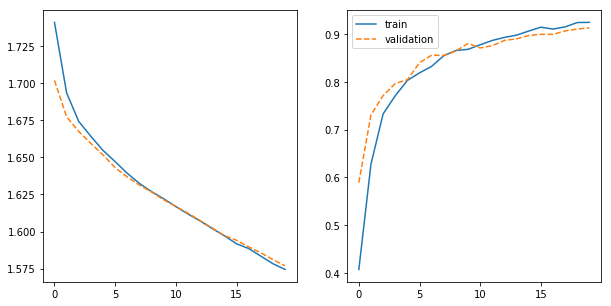

In [0]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.epoch,history.history['loss'],label='train')
plt.plot(history.epoch,history.history['val_loss'],'--',label='validation')
plt.subplot(122)
plt.plot(history.epoch,history.history['accuracy'],label='train')
plt.plot(history.epoch,history.history['val_accuracy'],'--',label='validation')
plt.legend()
plt.show()

In [0]:
# img_test = Image.open('test.jpg')
# img_test = img_test.resize((width, height))
# img_test = np.asarray(img_test, dtype='float32')
# img_test = img_test / 127.5 - 1
# img_test = np.expand_dims(img_test,0)
# temp = mobile_net.predict(img_test)
# snake_model.predict(temp)

array([[1.4244671e-02, 9.8565513e-01, 9.0160608e-09, 7.5417207e-05,
        2.3780238e-05, 1.0160327e-06]], dtype=float32)

## Step 4: Save Model

In [0]:
!mkdir model
snake_model.save('./model/model.h5')

In [0]:
!sudo pip install tensorflowjs

In [0]:
!mkdir tfjs_model
!tensorflowjs_converter --input_format=keras ./model/model.h5 ./tfjs_model

In [0]:
!zip -r model.zip ./tfjs_model/

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard13of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard11of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard4of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard8of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard6of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard7of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard5of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard1of13.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 71%)
  adding: tfjs_model/group1-shard9of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard2of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard12of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard3of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard10of13.bin (deflated 8%)


In [0]:
!rm -rf tfjs_model
!rm -rf model
!rm -rf model.zip